# Part 2 : Is having party support useful to furthering a political agenda?

In [26]:
import warnings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import codecs
import glob
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.neighbors import kneighbors_graph

import networkx as nx

from scipy.sparse.linalg import eigs

import data_loading


In [27]:
full_votes = pd.read_csv("../generated/full_votes.csv.gz")

/Users/marcglettig/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (20,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
votes = pd.read_csv("../generated/votes.csv.gz",index_col=0)

In [29]:
members = pd.read_csv("../generated/members.csv")

### General attendence vs attendence at motions from party

> First let's get the set of members for each party

In [30]:
party_members = members[['PartyAbbreviation', 'LastName', 'FirstName']]\
                    .groupby('PartyAbbreviation').agg(lambda x: list(x))
party_members['Member_set'] = party_members.apply(lambda x: set(zip(x['LastName'], x['FirstName'])), axis=1)
party_members = party_members.drop(['LastName', 'FirstName'], axis=1).reset_index()

> Then lets see the set difference for members that attend to the members of the parties. We can asses this with the Jaccard Similarity

In [31]:
def jaccard(A, B):
    return len(A.intersection(B))/len(A.union(B))

### Get the parties initiating a business item

As the party initiating a business item is not stated in the data provided, we used webscraping to collect information about the initiators of a business item. If the text describing the initiators contains a name of a councillor, we assume that the business item has been issued by the party of this councillor. This leads us to the party initiating a business item. Note that in many cases, there is no party initiating the business item. Often responsible commities are issuing such items. These commities are most likely composed out of many councillors from different parties and not a single party can be attributed.

In [33]:
def html_file_to_affair(file):
    ms_items = file.find_all('div', class_="ms-srch-item")
    headers = [item.find('h4', class_='ms-srch-item-area') for item in ms_items]
    IDs = [header.a.get('href')[-8:] for header in headers]
    affairs = [header.a.string for header in headers]
    return list(zip(IDs, affairs))

def get_councillor(councillors, item):
    for councillor in councillors:
        if fuzz.token_set_ratio(item, councillor) > 90:
            return councillor
    return None

The HTML files indicated are from https://www.parlament.ch/de/ratsbetrieb/suche-curia-vista where we collect all business items.

In [34]:
'''Used to attribute the party to the names of the councillors'''
unique_name_party = full_votes[['AffairShortId','CouncillorName', 'PartyAbbreviation']].drop_duplicates()\
                    .set_index(['CouncillorName','AffairShortId'])

super_dict = unique_name_party.to_dict('index')

def get_party(Councillor, AffairID):
    try: 
        return super_dict[(Councillor, AffairID)]['PartyAbbreviation']
    except KeyError:
        return 0
    except:
        return 0

In [35]:
'''
Web scraping, only to be done to create the business_items file.

path = '../generated/business_items'
affairs_ = []
for filename in glob.glob(os.path.join(path, '*.html')):
    f=codecs.open(filename)
    document= BeautifulSoup(f.read(), 'html.parser')
    affairs_.extend(html_file_to_affair(document))

df = pd.DataFrame(affairs_, columns=['AffairID', 'BusinessItem']) 
df.to_csv('../generated/business_items.csv')'''

df = pd.read_csv('../generated/business_items.csv')
names = set(full_votes['CouncillorName'].unique())
df['Councillor'] = df.apply (lambda row: get_councillor(names, row['BusinessItem']), axis=1)
df['Party'] = df.apply(lambda row: get_party(row['Councillor'], int(row['AffairID'])), axis=1)
df['AffairID'] = df['AffairID'].astype('int32')
df_ = df.set_index('AffairID')[['BusinessItem','Councillor','Party']]
full_votes_ = full_votes.join(df_, on='AffairShortId')

Now we have added the Party initating an affair if there is one.

### We are ready to calculate the presence at votes

We create a set of all the councillor names that voted in a particular business item.

In [41]:
presence_at_votes = full_votes_[full_votes['CouncillorNotParticipated'] == True]
presence_at_votes = presence_at_votes[['VoteRegistrationNumber', 'CouncillorNotParticipated', 'LastName', 'FirstName', 'Party']]\
                    .groupby('VoteRegistrationNumber')\
                    .agg(lambda x: list(x))
presence_at_votes['Party'] = presence_at_votes['Party'].apply(lambda row: row[0])
presence_at_votes['Present_Set'] = presence_at_votes.apply(lambda x: set(zip(x['LastName'], x['FirstName'])), axis=1)
presence_at_votes = presence_at_votes.drop(['LastName', 'FirstName'], axis=1).reset_index()

/Users/marcglettig/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [45]:
'''Cross-Join to compare the party member set with the voting set'''
product = (
    party_members.assign(key=1)
    .merge(presence_at_votes.assign(key=1), on="key")
    .drop("key", axis=1)
)

product['party_presence'] = product.apply(lambda x: jaccard(x['Member_set'], x['Present_Set']), axis=1)
product = product.drop(['Member_set', 'Present_Set'], axis=1)

From the joined dataframe we apply the Jaccard difference and find the attendence score for each party at each vote. This can now be averaged over the case where we keep all votes or only keeping the votes about items from each party.

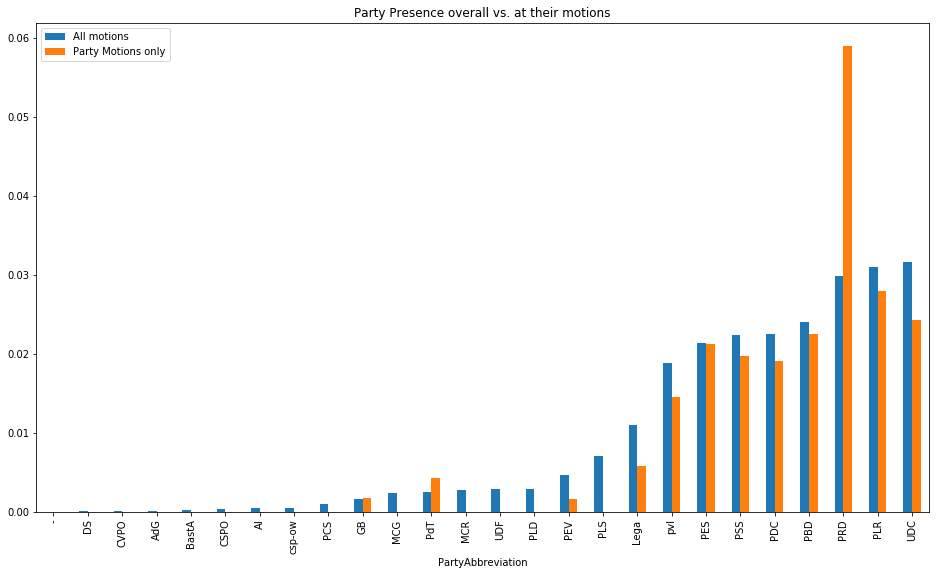

In [59]:
product_ = product[product['Party'] != 0]
product_ = product_[product_['Party'] == product_['PartyAbbreviation']]
party_party_presence = product_[['PartyAbbreviation', 'party_presence']].groupby('PartyAbbreviation').agg(np.mean)
mean_party_presence = product[['PartyAbbreviation', 'party_presence']].groupby('PartyAbbreviation').agg(np.mean)

mean_party_presence['All motions'] = mean_party_presence['party_presence']
mean_party_presence['Party Motions only'] = party_party_presence['party_presence']

final_ = mean_party_presence.drop('party_presence', axis=1).sort_values(by='All motions')
final_.plot(kind='bar', figsize=(16,9), title='Party Presence overall vs. at their motions');

We can state from the graph that the presence of a party at their votes is not greatly influenced by the fact of a motion being from their proper party or not. Even though inside the parties there are sometimes great differences. But overall there is no trend to be seen.